In [199]:

import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig, create_optimizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

import spacy
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk

In [46]:
df = pd.read_csv('data/data_2.csv')

In [47]:
df['isfake'].value_counts()

isfake
0    14963
1     8811
Name: count, dtype: int64

In [49]:
X = df['text']
y = df['isfake']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [50]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=300)

train_encoding = tokenize(X_train.tolist())
test_encoding = tokenize(X_test.tolist())
val_encoding = tokenize(X_val.tolist())

In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encoding),
    y_train.values
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encoding),
    y_test.values
))

valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encoding),
    y_val.values
))

In [52]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2)
config.seq_classif_dropout = 0.2

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

epochs = 6
batch_size = 16
total_num_train_samples = len(train_dataset)
num_batches = total_num_train_samples // batch_size
if total_num_train_samples % batch_size != 0:
    num_batches += 1
total_train_steps = num_batches * epochs
warmup_steps = total_train_steps * 0.1


optimizer, _ = create_optimizer(
    init_lr=5e-5,
    num_train_steps=total_train_steps,  # number of batches * number of epochs
    num_warmup_steps=warmup_steps,      # 0.1 * total_train_steps
    weight_decay_rate=0.01              # rate of weight decay
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

labels = []
for _, label in train_dataset:
    labels.append(label.numpy())

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

history = model.fit(
    train_dataset.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=test_dataset.batch(batch_size),
    callbacks=[es],
    class_weight=class_weight_dict
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/6
892/892 [==============================] - 2867s 3s/step - loss: 0.2571 - accuracy: 0.8836 - val_loss: 0.1308 - val_accuracy: 0.9485
Epoch 2/6
892/892 [==============================] - 2892s 3s/step - loss: 0.0808 - accuracy: 0.9720 - val_loss: 0.0761 - val_accuracy: 0.9727
Epoch 3/6
892/892 [==============================] - 2851s 3s/step - loss: 0.0309 - accuracy: 0.9900 - val_loss: 0.0824 - val_accuracy: 0.9701
Epoch 4/6
892/892 [==============================] - 2829s 3s/step - loss: 0.0133 - accuracy: 0.9955 - val_loss: 0.1053 - val_accuracy: 0.9746
Epoch 5/6
892/892 [==============================] - 2827s 3s/step - loss: 0.0047 - accuracy: 0.9981 - val_loss: 0.1172 - val_accuracy: 0.9748


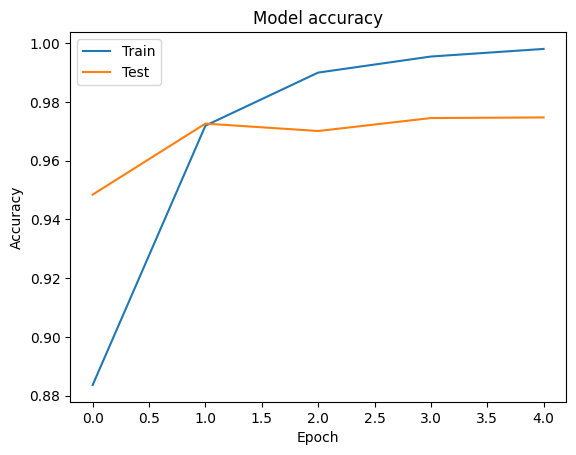

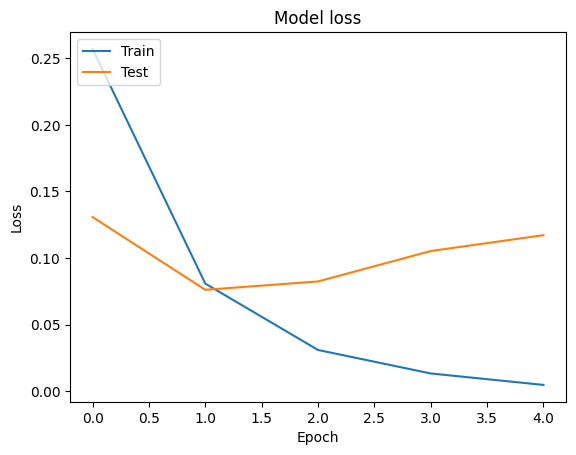

In [53]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [59]:
model.save_pretrained('models/distilbert_model_best.h5')

In [60]:
tokenizer.save_pretrained('tokenizers/distilbert_tokenizer_best')

('tokenizers/distilbert_tokenizer_perfect_run/tokenizer_config.json',
 'tokenizers/distilbert_tokenizer_perfect_run/special_tokens_map.json',
 'tokenizers/distilbert_tokenizer_perfect_run/vocab.txt',
 'tokenizers/distilbert_tokenizer_perfect_run/added_tokens.json')

In [49]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_119 (Dropout)       multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [200]:
## Download the dictionary for stopwords
nltk.download('stopwords')
## Get the set of stopwords
stop_words_set = set(stopwords.words('english'))
## Load English tokenizer from spacy
nlp = English()
spacy_tokenizer = nlp.tokenizer ## make instance
## Create function to clean text -- lowercase, remove non alphanumeric, remove stop words
def optimized_preprocess(text): ## Takes in a list of texts, i.e. the entire corpus
    # Tokenize using spaCy’s tokenizer
    # for text in texts:
    tokens = [token.text.lower() for token in spacy_tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
    cleaned_query= ' '.join(word for word in tokens)
    return cleaned_query

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewieraci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [201]:
new_df_examples = pd.read_csv('data/train.csv')
fake_examples = new_df_examples[new_df_examples['label'] == 1].sample(100)
true_examples = new_df_examples[new_df_examples['label'] == 0].sample(100)

In [202]:
fake_examples

,id,title,author,text,label
17615,17615,Israeli official secretly visits Dubai: Report,Press TV,Israeli official secretly visits Dubai: Report...,1
14732,14732,"As Natives Declare Treaty Rights, Police Admit...",Eddy Lavine,posted by Eddie Authorities in North Dakota ma...,1
12102,12102,Endlich: Esso-Tankstellen bieten jetzt auch ve...,noreply@blogger.com (Der Postillon),"Donnerstag, 17. November 2016 Endlich: Esso-Ta...",1
5543,5543,Does The Russian Government Have A Reality Dis...,NaN,License DMCA \nDuring the decades-long Cold Wa...,1
14437,14437,The Factless Fact-Checkers,EdJenner,"Go to Article \nDaniel Greenfield, a Shillman ...",1
...,...,...,...,...,...
4147,4147,Who reckons this might not be a legit iPhone c...,Sausage Machine,Next Swipe left/right Who reckons this might n...,1
18133,18133,Didn’t Vaccines Eradicate Diseases? An Untold ...,Joe Martino,"If you’ve been paying attention, you probably ...",1
1016,1016,Thank You FBI: The Clinton Email Investigation...,The Doc,Home » Headlines » World News » Thank You FBI:...,1
16222,16222,"Anti-Trump violence sweeps the nation, ignored...",Howard Portnoy,Print \nWhile the mainstream media has been wo...,1


In [203]:
true_examples

,id,title,author,text,label
2666,2666,Donald Trump News Conference Gets the ‘S.N.L.’...,Dave Itzkoff,If Donald J. Trump’s first news conference as ...,0
6040,6040,Spokesman’s Death Will Have Islamic State Turn...,"Eric Schmitt, Rukmini Callimachi and Anne Barnard",WASHINGTON — The reported death of the Isla...,0
3262,3262,G.O.P. Senators Hope to Speed Trump Cabinet Co...,Jennifer Steinhauer and Matt Flegenheimer,WASHINGTON — Senate Republicans will move t...,0
9535,9535,Trump a Working-Class Hero? A Blue-Collar Town...,Richard Fausset,"YOUNGSTOWN, Ohio — “Is this idiot for Trump...",0
16250,16250,Fake News: WaPo’s Erik Wemple Vindicates Breit...,Jerome Hudson,Washington Post writer Erik Wemple has updated...,0
...,...,...,...,...,...
20180,20180,Aid Convoy Is Hit in Syria as Cease-Fire Falte...,Anne Barnard and Michael R. Gordon,"BEIRUT, Lebanon — A humanitarian aid convoy...",0
17627,17627,"Matteo Salvini: Europe ’Soft’, Islam Incompati...",Virginia Hale,"“If you want to live in peace, you have to pre...",0
2010,2010,Report: Melania and Barron Trump Will Move to ...,Katherine Rodriguez,First Lady Melania Trump and son Barron will m...,0
6047,6047,"Friday Mailbag: Faulty Headlines, Insensitive ...",Liz Spayd with Evan Gershkovich,"On Wednesday, President Trump rescinded protec...",0


In [204]:
fake_check_list = []
for text in fake_examples.text:
    random_input = optimized_preprocess(text)
    random_input = tokenizer.encode_plus(
        random_input,
        add_special_tokens=True,
        max_length=300,
        truncation = True,
        padding='max_length', 
        return_attention_mask=True,
        return_tensors="tf"
    )
    input_ids = random_input['input_ids']
    attention_mask = random_input['attention_mask']


    predictions = model(input_ids, attention_mask=attention_mask)
    probabilities = tf.nn.softmax(predictions.logits, axis=-1)


    predicted_class = tf.argmax(probabilities, axis=-1).numpy()
    class_names = ['Real', 'Fake']
    fake_check_list.append([f"The article is predicted as: {class_names[predicted_class[0]]}", f"Probabilities per class: {probabilities.numpy()[0]}"])
fake_check_list

[['The article is predicted as: Fake',
  'Probabilities per class: [0.01897141 0.9810286 ]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [9.8955189e-04 9.9901044e-01]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [5.127098e-04 9.994873e-01]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [5.763716e-04 9.994236e-01]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.13614419 0.8638558 ]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [5.5956474e-04 9.9944037e-01]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.17143102 0.828569  ]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.1827438  0.81725615]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.00276778 0.99723226]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.00867066 0.9913293 ]'],
 ['The article is predicted as: Fake',
 

In [205]:
real_check_list = []
for text in true_examples.text:
    random_input = optimized_preprocess(text)
    random_input = tokenizer.encode_plus(
        random_input,
        add_special_tokens=True,
        max_length=300,
        truncation = True,
        padding='max_length', 
        return_attention_mask=True,
        return_tensors="tf"
    )
    input_ids = random_input['input_ids']
    attention_mask = random_input['attention_mask']


    predictions = model(input_ids, attention_mask=attention_mask)
    probabilities = tf.nn.softmax(predictions.logits, axis=-1)


    predicted_class = tf.argmax(probabilities, axis=-1).numpy()
    class_names = ['Real', 'Fake']
    real_check_list.append([f"The article is predicted as: {class_names[predicted_class[0]]}", f"Probabilities per class: {probabilities.numpy()[0]}"])
real_check_list

[['The article is predicted as: Real',
  'Probabilities per class: [0.7747786  0.22522137]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.99893874 0.00106128]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.99892396 0.00107606]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.9683012  0.03169879]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.49658895 0.50341105]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.4661855  0.53381443]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.9802142  0.01978589]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.8274474  0.17255262]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.89047885 0.1095212 ]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.9971717  0.00282827]'],
 ['The article is predicted as: Real',
  'Probabilities per 

In [206]:
# Do Not Run This Cell
result_dict = {}
test_num = 1

In [207]:

# Store test results
result_dict[f'test_{test_num}'] = {
    'fake_examples': {
        'indices': fake_examples.index.tolist(),
        'scores': fake_check_list
    },
    'true_examples': {
        'indices': true_examples.index.tolist(),
        'scores': real_check_list
    }
}
test_num += 1

In [208]:
result_dict.keys()

dict_keys(['test_1'])

In [217]:
for test in result_dict.keys():
    count = 0
    for result in result_dict[test]['fake_examples']['scores']:
        for row in result:
            if "Real" in row:
                count += 1
                print(result)
print(f'Accuracy = {100 - count}%')
    

['The article is predicted as: Real', 'Probabilities per class: [0.9954122  0.00458781]']
['The article is predicted as: Real', 'Probabilities per class: [0.7153792  0.28462085]']
['The article is predicted as: Real', 'Probabilities per class: [0.75657284 0.24342717]']
['The article is predicted as: Real', 'Probabilities per class: [0.8353375  0.16466251]']
['The article is predicted as: Real', 'Probabilities per class: [0.7359746  0.26402533]']
['The article is predicted as: Real', 'Probabilities per class: [0.8572175  0.14278246]']
['The article is predicted as: Real', 'Probabilities per class: [0.8896977  0.11030227]']
['The article is predicted as: Real', 'Probabilities per class: [0.73555225 0.26444772]']
['The article is predicted as: Real', 'Probabilities per class: [0.657298   0.34270206]']
Accuracy = 91%


In [218]:
for test in result_dict.keys():
    count = 0
    for result in result_dict[test]['true_examples']['scores']:
        for row in result:
            if "Fake" in row:
                count += 1
                print(result)
print(f'Accuracy = {100 - count}%')

['The article is predicted as: Fake', 'Probabilities per class: [0.49658895 0.50341105]']
['The article is predicted as: Fake', 'Probabilities per class: [0.4661855  0.53381443]']
['The article is predicted as: Fake', 'Probabilities per class: [0.47251198 0.52748805]']
['The article is predicted as: Fake', 'Probabilities per class: [0.21802633 0.7819736 ]']
['The article is predicted as: Fake', 'Probabilities per class: [0.37755883 0.6224412 ]']
['The article is predicted as: Fake', 'Probabilities per class: [0.34806737 0.6519326 ]']
['The article is predicted as: Fake', 'Probabilities per class: [0.0036857  0.99631435]']
['The article is predicted as: Fake', 'Probabilities per class: [0.45047548 0.54952455]']
['The article is predicted as: Fake', 'Probabilities per class: [0.06572881 0.9342712 ]']
Accuracy = 91%


In [219]:
no_preproc_fake_check_list = []
for text in fake_examples.text:
    random_input = text
    random_input = tokenizer.encode_plus(
        random_input,
        add_special_tokens=True,
        max_length=300,
        truncation = True,
        padding='max_length', 
        return_attention_mask=True,
        return_tensors="tf"
    )
    input_ids = random_input['input_ids']
    attention_mask = random_input['attention_mask']


    predictions = model(input_ids, attention_mask=attention_mask)
    probabilities = tf.nn.softmax(predictions.logits, axis=-1)


    predicted_class = tf.argmax(probabilities, axis=-1).numpy()
    class_names = ['Real', 'Fake']
    no_preproc_fake_check_list.append([f"The article is predicted as: {class_names[predicted_class[0]]}", f"Probabilities per class: {probabilities.numpy()[0]}"])
no_preproc_fake_check_list

[['The article is predicted as: Real',
  'Probabilities per class: [0.54826236 0.45173767]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.00308301 0.996917  ]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.00255127 0.99744874]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [8.978585e-04 9.991021e-01]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.47843874 0.52156126]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.00131483 0.9986852 ]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.19812669 0.80187327]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.09516364 0.9048364 ]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.00466354 0.9953365 ]'],
 ['The article is predicted as: Fake',
  'Probabilities per class: [0.02261471 0.97738534]'],
 ['The article is predicted as: Fake',
  'Probabilities 

In [225]:
no_preproc_real_check_list = []
for text in true_examples.text:
    random_input = text
    random_input = tokenizer.encode_plus(
        random_input,
        add_special_tokens=True,
        max_length=300,
        truncation = True,
        padding='max_length', 
        return_attention_mask=True,
        return_tensors="tf"
    )
    input_ids = random_input['input_ids']
    attention_mask = random_input['attention_mask']


    predictions = model(input_ids, attention_mask=attention_mask)
    probabilities = tf.nn.softmax(predictions.logits, axis=-1)


    predicted_class = tf.argmax(probabilities, axis=-1).numpy()
    class_names = ['Real', 'Fake']
    no_preproc_real_check_list.append([f"The article is predicted as: {class_names[predicted_class[0]]}", f"Probabilities per class: {probabilities.numpy()[0]}"])
no_preproc_real_check_list

[['The article is predicted as: Real',
  'Probabilities per class: [0.99465466 0.00534533]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.99786854 0.00213145]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.9988004  0.00119962]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.99306446 0.00693553]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.6590663  0.34093365]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.97674984 0.02325021]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.9946109  0.00538915]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.9502605  0.04973949]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.9599237  0.04007629]'],
 ['The article is predicted as: Real',
  'Probabilities per class: [0.9904191  0.00958092]'],
 ['The article is predicted as: Real',
  'Probabilities per 

In [226]:
# Do Not Run This Cell
no_preproc_result_dict = {}
test_num_no_preproc = 1

In [227]:
# Store test results
no_preproc_result_dict[f'test_{test_num}'] = {
    'fake_examples': {
        'indices': fake_examples.index.tolist(),
        'scores': no_preproc_fake_check_list
    },
    'true_examples': {
        'indices': true_examples.index.tolist(),
        'scores': no_preproc_real_check_list
    }
}
test_num_no_preproc += 1

In [228]:
for test in no_preproc_result_dict.keys():
    count = 0
    for result in no_preproc_result_dict[test]['fake_examples']['scores']:
        for row in result:
            if "Real" in row:
                count += 1
                print(result)
print(f'Accuracy = {100 - count}%')

['The article is predicted as: Real', 'Probabilities per class: [0.54826236 0.45173767]']
['The article is predicted as: Real', 'Probabilities per class: [0.5379773  0.46202266]']
['The article is predicted as: Real', 'Probabilities per class: [0.9113224  0.08867761]']
['The article is predicted as: Real', 'Probabilities per class: [0.51553375 0.48446625]']
['The article is predicted as: Real', 'Probabilities per class: [0.64685667 0.3531433 ]']
['The article is predicted as: Real', 'Probabilities per class: [0.7506114 0.2493886]']
['The article is predicted as: Real', 'Probabilities per class: [0.8863857  0.11361427]']
['The article is predicted as: Real', 'Probabilities per class: [0.5917745  0.40822548]']
['The article is predicted as: Real', 'Probabilities per class: [0.78124493 0.21875505]']
['The article is predicted as: Real', 'Probabilities per class: [0.86561775 0.13438232]']
['The article is predicted as: Real', 'Probabilities per class: [0.5186145  0.48138547]']
['The articl

In [229]:
for test in no_preproc_result_dict.keys():
    count = 0
    for result in no_preproc_result_dict[test]['true_examples']['scores']:
        for row in result:
            if "Fake" in row:
                count += 1
                print(result)
print(f'Accuracy = {100 - count}%')

['The article is predicted as: Fake', 'Probabilities per class: [0.24210732 0.75789267]']
['The article is predicted as: Fake', 'Probabilities per class: [0.32189783 0.6781022 ]']
Accuracy = 98%
